In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotx
import pandas as pd
from fastcore.xtras import load_pickle
from scipy.stats import sem

from gptchem.evaluator import find_learning_curve_intersection, fit_learning_curve, lc
from gptchem.settings import ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH, ONE_COL_GOLDEN_RATIO_HEIGHT_INCH

from gptchem.plotsettings import * 

%matplotlib inline

## Load results

In [37]:
all_out = glob("out/**/*.pkl")

In [38]:
all_out = [load_pickle(p) for p in all_out]

In [39]:
all_out

[{'tabpfn_metrics': {'accuracy': 0.6687116564417178,
   'acc_macro': 0.6687116564417178,
   'racc': 0.6687116564417178,
   'kappa': 0.0,
   'confusion_matrix': pycm.ConfusionMatrix(classes: [0, 1]),
   'f1_macro': 0.4007352941176471,
   'f1_micro': 0.6687116564417178,
   'frac_valid': 1.0,
   'all_y_true': (#326) [1,1,1,1,1,0,0,0,0,0...],
   'all_y_pred': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [40]:
extracted_res = []
xgboost_results = []
tabpfn_results = []
dummy_results = []

for out in all_out:
    res = {
        "train_size": out["train_size"],
        "frac_valid": out["frac_valid"],
        "accuracy": out["accuracy"],
        "f1_macro": out["f1_macro"],
        "f1_micro": out["f1_micro"],
        "kappa": out["kappa"],
    }

    xgb_res = {
        "train_size": out["train_size"],
        "accuracy": out["xgb_metrics"]["accuracy"],
        "f1_macro": out["xgb_metrics"]["f1_macro"],
        "f1_micro": out["xgb_metrics"]["f1_micro"],
        "kappa": out["xgb_metrics"]["kappa"],
    }

    tabpfn_res = {
        "train_size": out["train_size"],
        "accuracy": out["tabpfn_metrics"]["accuracy"],
        "f1_macro": out["tabpfn_metrics"]["f1_macro"],
        "f1_micro": out["tabpfn_metrics"]["f1_micro"],
        "kappa": out["tabpfn_metrics"]["kappa"],
    }

    dummy_res = {
        "train_size": out["train_size"],
        "accuracy": out["dummy_metrics"]["accuracy"],
        "f1_macro": out["dummy_metrics"]["f1_macro"],
        "f1_micro": out["dummy_metrics"]["f1_micro"],
        "kappa": out["dummy_metrics"]["kappa"],
    }

    extracted_res.append(res)
    xgboost_results.append(xgb_res)
    tabpfn_results.append(tabpfn_res)
    dummy_results.append(dummy_res)

In [41]:
res = pd.DataFrame(extracted_res)
xgboost_res = pd.DataFrame(xgboost_results)
tabpfn_res = pd.DataFrame(tabpfn_results)
dummy_res = pd.DataFrame(dummy_results)

In [42]:
grouped_res = res.groupby(["train_size"]).agg(["mean", "std", "count", sem])

In [43]:
grouped_xgboost_res = xgboost_res.groupby(["train_size"]).agg(["mean", "std", "count", sem])

In [44]:
grouped_dummy_res = dummy_res.groupby(["train_size"]).agg(["mean", "std", "count", sem])

In [45]:
grouped_tabpfn_res = tabpfn_res.groupby(["train_size"]).agg(["mean", "std", "count", sem])

In [46]:
grouped_res.loc[:]

frac_valid                  accuracy                            \
                 mean  std count  sem      mean       std count       sem   
train_size                                                                  
10                1.0  0.0     8  0.0  0.699695  0.023670     8  0.008369   
20                1.0  0.0     7  0.0  0.668920  0.062363     7  0.023571   
50                1.0  0.0     7  0.0  0.751833  0.094236     7  0.035618   

            f1_macro                            f1_micro                  \
                mean       std count       sem      mean       std count   
train_size                                                                 
10          0.461524  0.062130     8  0.021966  0.699695  0.023670     8   
20          0.438760  0.037956     7  0.014346  0.668920  0.062363     7   
50          0.496054  0.065670     7  0.024821  0.751833  0.094236     7   

                         kappa                            
                 sem      mean       std count       sem  
train_size                                                
10          0.008369  0.023947  0.066072     8  0.023360  
20          0.023571 -0.026473  0.072442     7  0.027380  
50          0.035618  0.058570  0.089338     7  0.033766

In [47]:
grouped_tabpfn_res

accuracy                            f1_macro                  \
                mean       std count       sem      mean       std count   
train_size                                                                 
10          0.655967  0.030766     8  0.010877  0.422806  0.086272     8   
20          0.622552  0.081666     7  0.030867  0.437338  0.086246     7   
50          0.739496  0.103272     7  0.039033  0.452007  0.077154     7   

                      f1_micro                               kappa            \
                 sem      mean       std count       sem      mean       std   
train_size                                                                     
10          0.030502  0.655967  0.030766     8  0.010877  0.036583  0.110236   
20          0.032598  0.622552  0.081666     7  0.030867  0.018613  0.121532   
50          0.029161  0.739496  0.103272     7  0.039033  0.021110  0.106668   

                            
           count       sem  
train_size                  
10             8  0.038974  
20             7  0.045935  
50             7  0.040317

In [48]:
grouped_xgboost_res

accuracy                            f1_macro                  \
                mean       std count       sem      mean       std count   
train_size                                                                 
10          0.628087  0.074443     8  0.026320  0.480589  0.124031     8   
20          0.635161  0.065995     7  0.024944  0.472923  0.101502     7   
50          0.728261  0.099291     7  0.037529  0.458145  0.071482     7   

                      f1_micro                               kappa            \
                 sem      mean       std count       sem      mean       std   
train_size                                                                     
10          0.043851  0.628087  0.074443     8  0.026320  0.049680  0.205161   
20          0.038364  0.635161  0.065995     7  0.024944  0.052979  0.151008   
50          0.027018  0.728261  0.099291     7  0.037529  0.013623  0.095635   

                            
           count       sem  
train_size                  
10             8  0.072535  
20             7  0.057076  
50             7  0.036146

In [49]:
grouped_dummy_res

accuracy                            f1_macro                  \
                mean       std count       sem      mean       std count   
train_size                                                                 
10          0.647421  0.011096     8  0.003923  0.392967  0.004091     8   
20          0.538697  0.194958     7  0.073687  0.339894  0.093997     7   
50          0.750029  0.116098     7  0.043881  0.426453  0.037476     7   

                      f1_micro                           kappa                  
                 sem      mean       std count       sem  mean  std count  sem  
train_size                                                                      
10          0.001446  0.647421  0.011096     8  0.003923   0.0  0.0     8  0.0  
20          0.035528  0.538697  0.194958     7  0.073687   0.0  0.0     7  0.0  
50          0.014164  0.750029  0.116098     7  0.043881   0.0  0.0     7  0.0

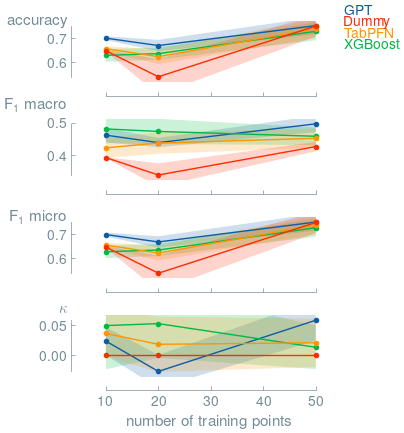

In [52]:

fig, ax = plt.subplots(
    4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH), sharex="all"
)

# plot the binary case, i.e. num_classes = 2

for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
    ax[i].plot(
        grouped_res.loc[ :].index,
        grouped_res.loc[:][metric]["mean"],
        marker="o",
        label="GPT",
    )
    ax[i].fill_between(
        grouped_res.loc[ :].index,
        grouped_res.loc[:][metric]["mean"] - grouped_res.loc[ :][metric]["sem"],
        grouped_res.loc[ :][metric]["mean"] + grouped_res.loc[ :][metric]["sem"],
        alpha=0.2,
    )

    range_frame(
        ax[i],
          grouped_res.loc[ :].index,
          np.stack(
            [ grouped_res.loc[:][metric]["mean"],
            grouped_xgboost_res.loc[:][metric]["mean"],
             grouped_tabpfn_res.loc[ :][metric]["mean"],
    grouped_dummy_res.loc[ :][metric]["mean"],
            ]
          ).flatten()
    )

    ax[i].plot(
        grouped_xgboost_res.loc[ :].index,
        grouped_xgboost_res.loc[ :][metric]["mean"],
        marker="o",
        label="XGBoost",
    )
    ax[i].fill_between(
        grouped_xgboost_res.loc[ :].index,
        grouped_xgboost_res.loc[:][metric]["mean"]
        - grouped_xgboost_res.loc[ :][metric]["sem"],
        grouped_xgboost_res.loc[:][metric]["mean"]
        + grouped_xgboost_res.loc[:][metric]["sem"],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_tabpfn_res.loc[ :].index,
        grouped_tabpfn_res.loc[ :][metric]["mean"],
        marker="o",
        label="TabPFN",
    )
    ax[i].fill_between(
        grouped_tabpfn_res.loc[ :].index,
        grouped_tabpfn_res.loc[:][metric]["mean"]
        - grouped_tabpfn_res.loc[ :][metric]["sem"],
        grouped_tabpfn_res.loc[ :][metric]["mean"]
        + grouped_tabpfn_res.loc[:][metric]["sem"],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_dummy_res.loc[ :].index,
        grouped_dummy_res.loc[ :][metric]["mean"],
        marker="o",
        label="Dummy",
    )
    ax[i].fill_between(
        grouped_dummy_res.loc[ :].index,
        grouped_dummy_res.loc[:][metric]["mean"]
        - grouped_dummy_res.loc[ :][metric]["sem"],
        grouped_dummy_res.loc[ :][metric]["mean"]
        + grouped_dummy_res.loc[:][metric]["sem"],
        alpha=0.2,
    )

ylabel_top("accuracy", ax=ax[0], x_pad=0.05, y_pad=0.06)
ylabel_top(r"F$_{1}$ macro", ax=ax[1], x_pad=0.05, y_pad=0.06)
ylabel_top(r"F$_{1}$ micro", ax=ax[2], x_pad=0.05, y_pad=0.06)
ylabel_top(r"$\kappa$", ax=ax[3], x_pad=0.05, y_pad=0.06)
ax[-1].set_xlabel("number of training points", labelpad=4)
matplotx.line_labels(ax=ax[0])
plt.subplots_adjust(hspace=.6, top=1, bottom=.2)

fig.savefig("mof_synthesizability-classification_results_2.pdf", bbox_inches="tight")

In [35]:
find_learning_curve_intersection(
    grouped_res.loc[2, :]["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        grouped_xgboost_res.loc[2, :].index,
        grouped_xgboost_res.loc[2, :]["f1_macro"]["mean"],
    )[0],
) / 10

KeyError: 2

In [ ]:
find_learning_curve_intersection(
    grouped_res.loc[2, :]["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        grouped_tabpfn_res.loc[2, :].index,
        grouped_tabpfn_res.loc[2, :]["f1_macro"]["mean"],
    )[0],
) / 10

KeyError: 2